<a href="https://colab.research.google.com/github/xymeo/mnist-handwriting-recognition/blob/main/handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to compare the accuracy of recognizing handwritten numbers, by training on the MNIST dataset two models - Convolutional Neural Networks and Multi Layered Perceptrons. 

The loss generated per epoch, and training and validation accuracies are compared for both models.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# The Dataset

We create the transforms for training and validation, create training and validation datasets, and Dataloaders. 

In [2]:
batch_size = 64
transform_training = transforms.Compose([
                                        transforms.RandomAffine(degrees=(20),
                                                                translate=(0.1, 0.1), 
                                                                scale=(0.8, 1.2)),
                                        transforms.RandomAdjustSharpness(sharpness_factor=2),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1310), (0.3085)),
                                        # transforms.Normalize((0.5), (0.5)),
                                        ])
transform_validation = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1310), (0.3085)),
                                        # transforms.Normalize((0.5), (0.5)),
                                        ])
training_set = datasets.MNIST(root="data", train=True, download=True, transform=transform_training)
validation_set = datasets.MNIST(root="data", train=False, download=True, transform=transform_validation)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_set, batch_size=batch_size)

### Visualizing the data and associated labels 

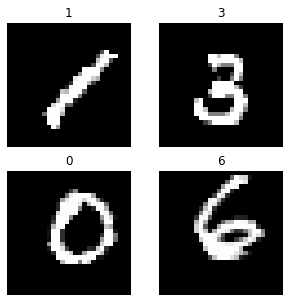

In [4]:
figure = plt.figure(figsize=(5, 5))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating Models



### Defining the Convolutional Neural Network (CNN)

In [5]:
class CNN(nn.Module):
  def __init__(self):
    
    super().__init__()
    
    self.conv_block = nn.Sequential(
      # 1st Conv Block 
      nn.Conv2d(in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),

      # 2nd Conv Block 
      nn.Conv2d(in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1,                   
                padding=2),
      nn.MaxPool2d(2, 2),
      nn.ReLU())
    
    self.fc1 = nn.Linear(2048, 10)
      
    
  def forward(self,x): 
    x = self.conv_block(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    return x


cnn = CNN() 
cnn


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

### Defining the Multi Layered Perceptron (MLP)

In [6]:
class Net(nn.Module):
  def __init__(self):
     super().__init__()
     self.activation = F.relu
     self.hl1 = nn.Linear(28*28, 128)
     self.hl2 = nn.Linear(128, 64)
     self.hl3 = nn.Linear(64, 10)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.activation(self.hl1(x))
    x = self.activation(self.hl2(x))
    x = self.hl3(x)
    return x 

mlp = Net()
mlp

Net(
  (hl1): Linear(in_features=784, out_features=128, bias=True)
  (hl2): Linear(in_features=128, out_features=64, bias=True)
  (hl3): Linear(in_features=64, out_features=10, bias=True)
)

### Defining Loss Function and Learning Rate

In [7]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01

# Training the Model 

In [8]:
def training_loop(model, learning_rate, num_epochs=10):

  training_loss_history, val_loss_history = [], []
  training_acc_history, val_acc_history = [], []

  # defining the Optimizer 
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  if torch.cuda.is_available():
    model = model.cuda() # Enable GPU 
  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      train_correct = 0 # Number of correct predictions in training set
      training_acc = 0.0
      
      for i, data in enumerate(tqdm(train_loader)):
          inputs, labels = data
          if torch.cuda.is_available():  # Enable GPU if available
              inputs, labels = inputs.cuda(), labels.cuda()
              
          optimizer.zero_grad() # Set gradients of all weights to 0 
          outputs = model(inputs) # Get the output 
          loss = loss_function(outputs, labels) # Calculate loss agains labels 
          loss.backward() # Calculate dloss/dx for parameters x 
          optimizer.step() # Parameter update

          _, preds = torch.max(outputs.data, 1)
          train_correct += (preds == labels).sum().item()
          train_loss += loss.item()
        
      training_acc = train_correct * 100 /len(training_set)
      print(f'Epoch {epoch + 1} training accuracy: {training_acc:.2f}% training loss: {train_loss/len(training_set):.5f}')
      training_loss_history.append(train_loss/len(training_set))
      training_acc_history.append(training_acc)

      val_loss = 0.0
      val_correct = 0 # Number of correct predictions in training set
      validation_acc = 0.0
      with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs) # Get output
            loss = loss_function(outputs, labels) 

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
      
      validation_acc = val_correct * 100 /len(validation_set)
      print(f'Epoch {epoch + 1} validation accuracy: {validation_acc:.2f}% validation loss: {val_loss/len(validation_set):.5f}')
      val_loss_history.append(val_loss/len(validation_set))
      val_acc_history.append(validation_acc)

  return training_loss_history, val_loss_history, training_acc_history, val_acc_history

### Training on CNN 

In [9]:
training_loss_history_cnn, val_loss_history_cnn, training_acc_history_cnn, val_acc_history_cnn = training_loop(cnn, learning_rate=learning_rate)

100%|██████████| 938/938 [00:28<00:00, 32.63it/s]


Epoch 1 training accuracy: 68.44% training loss: 0.01481
Epoch 1 validation accuracy: 91.84% validation loss: 0.00455


100%|██████████| 938/938 [00:21<00:00, 43.32it/s]


Epoch 2 training accuracy: 77.02% training loss: 0.01110
Epoch 2 validation accuracy: 92.58% validation loss: 0.00403


100%|██████████| 938/938 [00:22<00:00, 41.79it/s]


Epoch 3 training accuracy: 77.90% training loss: 0.01059
Epoch 3 validation accuracy: 93.41% validation loss: 0.00370


100%|██████████| 938/938 [00:21<00:00, 43.17it/s]


Epoch 4 training accuracy: 78.87% training loss: 0.01028
Epoch 4 validation accuracy: 93.32% validation loss: 0.00362


100%|██████████| 938/938 [00:21<00:00, 42.94it/s]


Epoch 5 training accuracy: 81.44% training loss: 0.00918
Epoch 5 validation accuracy: 94.63% validation loss: 0.00307


100%|██████████| 938/938 [00:21<00:00, 42.82it/s]


Epoch 6 training accuracy: 84.26% training loss: 0.00779
Epoch 6 validation accuracy: 95.70% validation loss: 0.00241


100%|██████████| 938/938 [00:22<00:00, 42.25it/s]


Epoch 7 training accuracy: 89.21% training loss: 0.00548
Epoch 7 validation accuracy: 95.92% validation loss: 0.00202


100%|██████████| 938/938 [00:22<00:00, 42.12it/s]


Epoch 8 training accuracy: 90.33% training loss: 0.00490
Epoch 8 validation accuracy: 96.95% validation loss: 0.00161


100%|██████████| 938/938 [00:21<00:00, 42.96it/s]


Epoch 9 training accuracy: 90.64% training loss: 0.00478
Epoch 9 validation accuracy: 96.29% validation loss: 0.00191


100%|██████████| 938/938 [00:21<00:00, 43.10it/s]


Epoch 10 training accuracy: 90.88% training loss: 0.00475
Epoch 10 validation accuracy: 96.98% validation loss: 0.00168


### Training on MLP  

In [10]:
training_loss_history_mlp, val_loss_history_mlp, training_acc_history_mlp, val_acc_history_mlp = training_loop(mlp, learning_rate=learning_rate)

100%|██████████| 938/938 [00:21<00:00, 43.60it/s]


Epoch 1 training accuracy: 77.45% training loss: 0.01108
Epoch 1 validation accuracy: 92.03% validation loss: 0.00400


100%|██████████| 938/938 [00:21<00:00, 43.33it/s]


Epoch 2 training accuracy: 85.71% training loss: 0.00758
Epoch 2 validation accuracy: 93.96% validation loss: 0.00319


100%|██████████| 938/938 [00:22<00:00, 42.25it/s]


Epoch 3 training accuracy: 87.35% training loss: 0.00691
Epoch 3 validation accuracy: 94.27% validation loss: 0.00310


100%|██████████| 938/938 [00:21<00:00, 43.87it/s]


Epoch 4 training accuracy: 88.22% training loss: 0.00649
Epoch 4 validation accuracy: 95.09% validation loss: 0.00268


100%|██████████| 938/938 [00:21<00:00, 43.90it/s]


Epoch 5 training accuracy: 88.90% training loss: 0.00631
Epoch 5 validation accuracy: 95.25% validation loss: 0.00281


100%|██████████| 938/938 [00:21<00:00, 43.67it/s]


Epoch 6 training accuracy: 88.92% training loss: 0.00634
Epoch 6 validation accuracy: 94.96% validation loss: 0.00296


100%|██████████| 938/938 [00:21<00:00, 44.04it/s]


Epoch 7 training accuracy: 89.31% training loss: 0.00613
Epoch 7 validation accuracy: 95.70% validation loss: 0.00252


100%|██████████| 938/938 [00:21<00:00, 43.78it/s]


Epoch 8 training accuracy: 89.63% training loss: 0.00607
Epoch 8 validation accuracy: 95.97% validation loss: 0.00242


100%|██████████| 938/938 [00:22<00:00, 41.99it/s]


Epoch 9 training accuracy: 89.63% training loss: 0.00609
Epoch 9 validation accuracy: 95.93% validation loss: 0.00242


100%|██████████| 938/938 [00:21<00:00, 43.85it/s]


Epoch 10 training accuracy: 89.86% training loss: 0.00615
Epoch 10 validation accuracy: 95.93% validation loss: 0.00253


# Visualizing Loss and Model Accuracy 

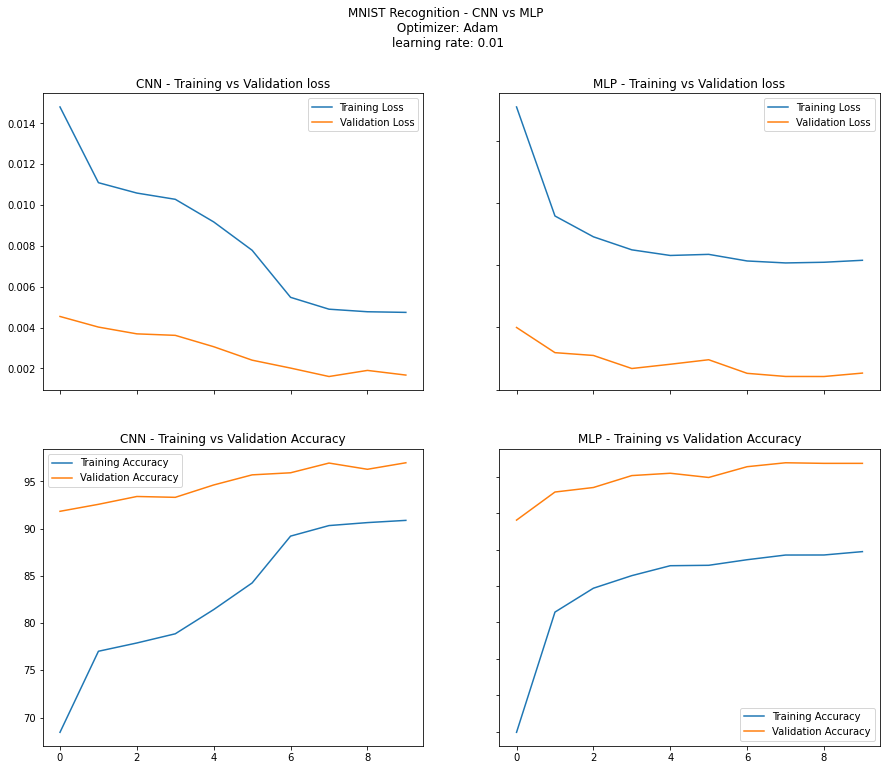

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('MNIST Recognition - CNN vs MLP \n Optimizer: Adam \nlearning rate: '+ format(learning_rate))

# CNN Model Loss 
ax1.plot(training_loss_history_cnn, label="Training Loss")
ax1.plot(val_loss_history_cnn, label="Validation Loss")
ax1.title.set_text('CNN - Training vs Validation loss')
ax1.legend()

# CNN Model Accuracy 
ax3.plot(training_acc_history_cnn, label="Training Accuracy")
ax3.plot(val_acc_history_cnn, label="Validation Accuracy")
ax3.title.set_text('CNN - Training vs Validation Accuracy')
ax3.legend()


# MLP Model Loss 
ax2.plot(training_loss_history_mlp, label="Training Loss")
ax2.plot(val_loss_history_mlp, label="Validation Loss")
ax2.title.set_text('MLP - Training vs Validation loss')
ax2.legend()


# MLP Model Accuracy 
ax4.plot(training_acc_history_mlp, label="Training Accuracy")
ax4.plot(val_acc_history_mlp, label="Validation Accuracy")
ax4.title.set_text('MLP - Training vs Validation Accuracy')
ax4.legend()


for ax in fig.get_axes():
    ax.label_outer()
